## Positive Linear RNN doing 2 Freqs

Does it modularise when we think it should?

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, value_and_grad, grad, jit, random
import jax.nn as jnn
from mpl_toolkits.mplot3d import Axes3D
import math
import optax

Since Wg_t + b = g_(t+1), we can minus b from all the gs and find the W

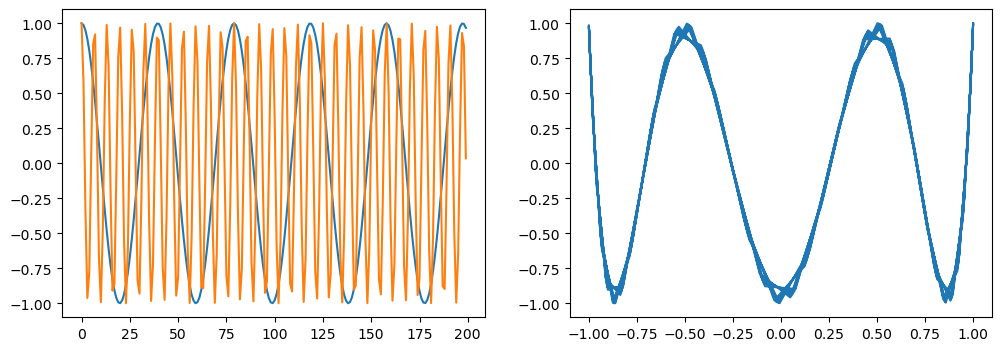

In [12]:
T = 200 # num timesteps
freqs = [1,6]
N = 10 # num neurons

num_freqs = len(freqs)

targets = np.zeros([num_freqs, T])
for freq_ind in range(num_freqs):
    targets[freq_ind,:] = np.cos(freqs[freq_ind]*np.arange(T)/(2*np.pi))

plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plt.plot(targets.T)

g = np.random.normal(0, 1, [N, T])
biases = np.random.normal(0,1, [N,])*0.1

params = {'g': g, 'biases':biases}

@jit
def generate_W(params):
    g_debiased = params["g"] - jnp.tile(params["biases"], [T,1]).T
    W = g_debiased[:,1:]@jnp.linalg.pinv(params["g"][:,:-1])
    return W

@jit
def loss_PI(params):
    W = generate_W(params)
    g_pred = W@params["g"][:,:-1] + params["biases"][:,None]
    return jnp.linalg.norm(g_pred - params["g"][:,1:])

loss_PI(params)

plt.subplot(1,2,2)
plt.plot(targets[0,:], targets[1,:])

In [108]:
@jit
def loss_pos(g):
    g_neg = (g - jnp.abs(g))/2
    L_pos = -jnp.sum(g_neg)
    return L_pos

@jit
def loss_act(g):
    return jnp.sum(jnp.power(g, 2))

@jit
def loss_weight(W):
    return jnp.sum(jnp.power(W, 2))

@jit
def generate_R(g, targets):
    g_bias = jnp.vstack([g, jnp.ones(g.shape[1])[None,:]])
    mat0 = jnp.matmul(g_bias, g_bias.T)
    mat1 = jnp.matmul(g_bias, targets.T)
    mat2 = jnp.matmul(jnp.linalg.inv(mat0 + 0.0001*jnp.eye(N+1)), mat1)
    return mat2

@jit
def loss_R(R, targets):
    return jnp.linalg.norm(generate_R(g, targets))**2

@jit
def loss_fit(g, R, targets):
    g_bias = jnp.vstack([g, jnp.ones(g.shape[1])[None,:]])
    preds = R.T@g_bias
    #preds_demeaned = preds - np.mean(preds, axis = 1)[:,None]
    return jnp.linalg.norm(targets - preds)

mu_fit = 1000
mu_G = 1
mu_W = 1
mu_R = 1
mu_pos = 10000
mu_PI = 5000
fit_thresh = 0.01
PI_thresh = 0.01

@jit
def loss(params, targets):
    g = params["g"]
    R = generate_R(g, targets)
    W = generate_W(params)
    
    return mu_fit*jnn.relu(loss_fit(g, R, targets)-fit_thresh) + mu_G*loss_act(g) + mu_W*loss_weight(W) + mu_R*loss_weight(R) + mu_pos*loss_pos(g)+mu_PI*jnn.relu(loss_PI(params)-PI_thresh)

@jit
def update(params, targets, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, targets)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value

random_seed = 43631313
learning_rate = 1e-4

re_init = 0
if re_init:
    key = random.PRNGKey(random_seed)
    g = random.normal(key, (N, T))
    biases = random.normal(key, (N,))*0.1
    params = {'g': g, 'biases':biases}

    optimizer = optax.adam(learning_rate)
    # Obtain the `opt_state` that contains statistics for the optimizer.
    opt_state = optimizer.init(params)

print(loss(params, targets))
min_loss = np.infty

55.910633


In [93]:
#params_save = params

In [109]:
grad_steps = 3000000
print_iter = 10000

for t in range(grad_steps):
    params, opt_state, loss = update(params, targets, opt_state)

    if t % print_iter == 0:
        g = params["g"]
        R = generate_R(g, targets)
        W = generate_W(params)

        L_f = loss_fit(g, R, targets)
        L_a = loss_act(g)
        L_w = loss_weight(W)
        L_R = loss_weight(R)
        L_p = loss_pos(g)
        L_PI = loss_PI(params)
        print(f"Step {t}, Loss: {loss:.5f}, Fit: {L_f:.5f}, Act: {L_a:.5f}, Wei: {L_w:.5f}, R: {L_R:.5f}, Pos: {L_p:.5f}, PI: {L_PI:.5f}")

        min_this_step = 0

    if loss < min_loss:
        params_best = params
        min_loss = loss
        if min_this_step == 0:
            print(f'New min! {loss}')
            min_this_step = 1

Step 0, Loss: 55.91063, Fit: 0.00672, Act: 24.40153, Wei: 9.75466, R: 21.75473, Pos: -0.00000, PI: 0.00362
New min! 55.9106330871582
Step 10000, Loss: 55.96298, Fit: 0.00603, Act: 24.46961, Wei: 9.74541, R: 21.74654, Pos: -0.00000, PI: 0.00602
New min! 55.793060302734375
Step 20000, Loss: 56.83372, Fit: 0.00849, Act: 24.41671, Wei: 9.80378, R: 21.77836, Pos: -0.00000, PI: 0.00792
Step 30000, Loss: 55.91924, Fit: 0.01678, Act: 24.42640, Wei: 9.74740, R: 21.74730, Pos: -0.00000, PI: 0.01164
New min! 55.781436920166016
Step 40000, Loss: 59.78055, Fit: 0.01278, Act: 24.38626, Wei: 9.79160, R: 21.77563, Pos: -0.00000, PI: 0.01234
New min! 55.758811950683594
Step 50000, Loss: 69.03742, Fit: 0.00386, Act: 24.37329, Wei: 9.84189, R: 21.72405, Pos: -0.00000, PI: 0.00525
Step 60000, Loss: 55.93317, Fit: 0.01325, Act: 24.40780, Wei: 9.75124, R: 21.77290, Pos: -0.00000, PI: 0.01193
Step 70000, Loss: 55.89804, Fit: 0.00395, Act: 24.38742, Wei: 9.76921, R: 21.74113, Pos: -0.00000, PI: 0.00574
Step 8

KeyboardInterrupt: 

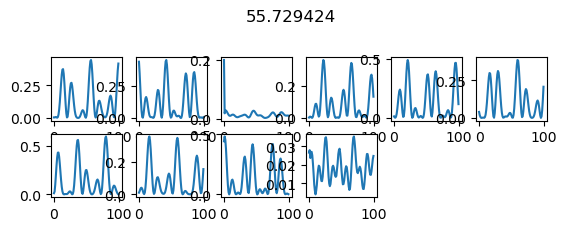

In [110]:
g_best = params_best["g"]

plot_rows = 5
plot_cols = 6

for n in range(N):
    plt.subplot(plot_rows,plot_cols,1+n)
    plt.plot(g_best[n,:])
plt.suptitle(min_loss)

frequencies = np.zeros([num_freqs*2, T])
for freq_ind in range(num_freqs):
    frequencies[2*freq_ind,:] = np.cos(freqs[freq_ind]*np.arange(T)/(2*np.pi))
    frequencies[2*freq_ind+1,:] = np.sin(freqs[freq_ind]*np.arange(T)/(2*np.pi))


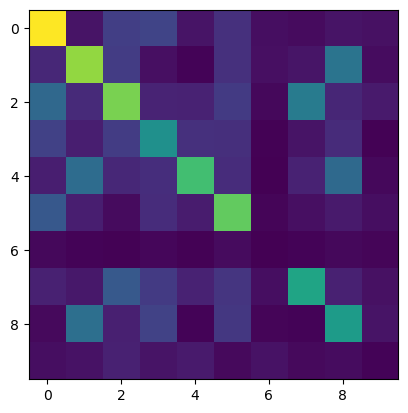

In [112]:
W = generate_W(params)

ordering = [0,1,4,5,6,7,2,3,8,9]

plt.imshow(np.abs(W[ordering,:][:,ordering]))

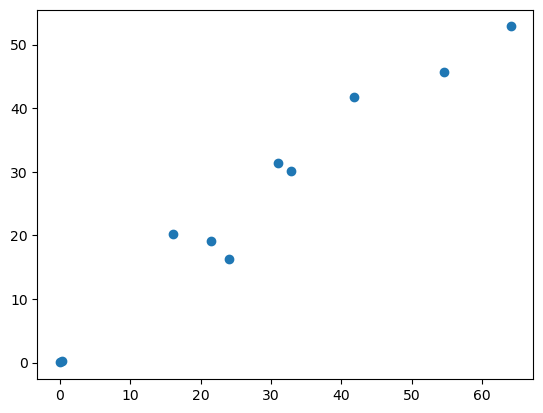

In [114]:
plt.scatter(mag_per_freq[:,0], mag_per_freq[:,1])

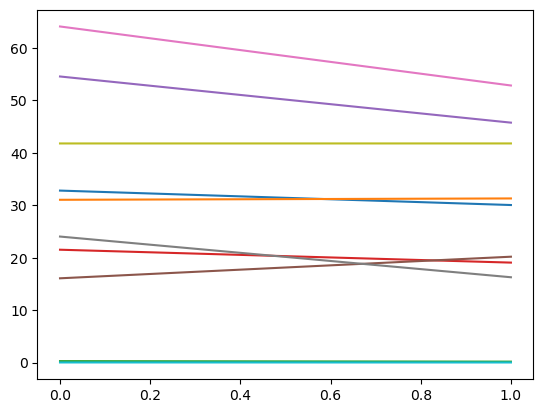

In [113]:
dot_prod = g_best@frequencies.T
mag = dot_prod**2
mag_per_freq = mag[:,::2] + mag[:,1::2]

plt.plot(mag_per_freq.T)

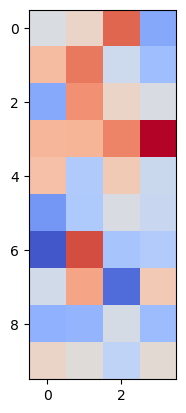

In [64]:
dot_prod = g_best@frequencies.T
plt.imshow(dot_prod, cmap = 'coolwarm')
color_val = np.max(np.abs(dot_prod))
plt.clim([-color_val, color_val])

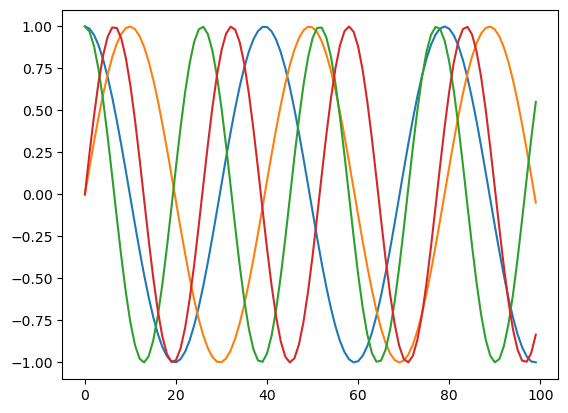

In [53]:
plt.plot(frequencies.T)

In [49]:
frequencies.shape

(4, 1000000)